In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas

In [47]:
import nengo
import nengo_spa as spa
import numpy as np
import pytry

class StroopTrial(pytry.PlotTrial):
    def params(self):
        self.param('number of dimensions in semantic pointer', D=16)
        self.param('number of each type of stimuli to test', n_stims=2)
        self.param('inter-stimulus interval', t_isi=0.05)
        self.param('stimulus presentation time', t_stim=0.15)
        self.param('direct automaticity', auto_direct=0.0)
        self.param('use neurons', use_neurons=True)
        
    def evaluate(self, p, plt):
        stimuli = []
        for i in range(p.n_stims):
            stimuli.append(('NEUTRAL%d'%i, 'COLOR%d'%i, 'neutral'))
        for i in range(p.n_stims):
            stimuli.append(('COLOR%d'%i, 'COLOR%d'%i, 'congruent'))
        for i in range(p.n_stims):
            stimuli.append(('COLOR%d'%((i+1)%p.n_stims), 'COLOR%d'%i, 'incongruent'))

        vocab = spa.Vocabulary(p.D, pointer_gen=np.random.RandomState(seed=p.seed))
        for i in range(p.n_stims):
            vocab.populate('NEUTRAL%d'%i)
            vocab.populate('COLOR%d'%i)
        vocab.populate('COLOR; WORD')

        model = spa.Network(seed=p.seed)
        with model:
            def word_func(t):
                index = int (t / (p.t_stim + p.t_isi))
                t = t % (p.t_stim + p.t_isi)
                if t < p.t_isi:
                    return '0'
                else:
                    return stimuli[index%len(stimuli)][0]
            def color_func(t):
                index = int (t / (p.t_stim + p.t_isi))
                t = t % (p.t_stim + p.t_isi)
                if t < p.t_isi:
                    return '0'
                else:
                    return stimuli[index%len(stimuli)][1]
            stim_w = spa.Transcode(word_func, output_vocab=vocab)
            stim_c = spa.Transcode(color_func, output_vocab=vocab) 
            stim_a = spa.Transcode('COLOR', output_vocab=vocab)

            wm = spa.State(vocab)
            
            (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~stim_a >> wm
            
            if p.auto_direct != 0:
                stim_w*p.auto_direct >> wm
                
            if not p.use_neurons:
                for ens in model.all_ensembles:
                    ens.neuron_type=nengo.Direct()
                

            p_output = nengo.Probe(wm.output, synapse=0.02)
            p_correct = nengo.Probe(stim_c.output)

        sim = nengo.Simulator(model, progress_bar=p.verbose)
        with sim:
            sim.run(p.n_stims*(p.t_isi+p.t_stim)*3)    

        v = np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output])
        steps = int((p.t_isi+p.t_stim)/sim.dt)
        scores = v[steps-2::steps]
        
        if plt:
            #plt.plot(sim.trange(), v)
            plt.plot(sim.trange(), sim.data[p_output].dot(vocab.vectors.T))
        
        return dict(
            scores=scores,
            stimuli=stimuli,
            neutral=np.mean(scores[:p.n_stims]),
            congruent=np.mean(scores[p.n_stims:p.n_stims*2]),
            incogruent=np.mean(scores[p.n_stims*2:]),            
        )

        

running StroopTrial#20200322-153100-645be9bf


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

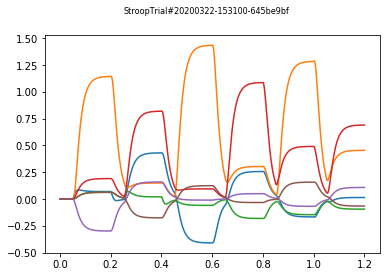

seed = 0
D = 64
n_stims = 2
t_isi = 0.05
t_stim = 0.15
auto_direct = 0.4
use_neurons = False
congruent = 1.2594733426334312
incogruent = 0.9861382556716052
neutral = 0.9807027873296235
scores = array([1.14272867, 0.81867691, 1.43335854, 1.08558815, 1.28270393,
       0.68957258])
stimuli = [('NEUTRAL0', 'COLOR0', 'neutral'), ('NEUTRAL1', 'COLOR1', 'neutral'), ('COLOR0', 'COLOR0', 'congruent'), ('COLOR1', 'COLOR1', 'congruent'), ('COLOR1', 'COLOR0', 'incongruent'), ('COLOR0', 'COLOR1', 'incongruent')]


{'congruent': 1.2594733426334312,
 'incogruent': 0.9861382556716052,
 'neutral': 0.9807027873296235,
 'scores': array([1.14272867, 0.81867691, 1.43335854, 1.08558815, 1.28270393,
        0.68957258]),
 'stimuli': [('NEUTRAL0', 'COLOR0', 'neutral'),
  ('NEUTRAL1', 'COLOR1', 'neutral'),
  ('COLOR0', 'COLOR0', 'congruent'),
  ('COLOR1', 'COLOR1', 'congruent'),
  ('COLOR1', 'COLOR0', 'incongruent'),
  ('COLOR0', 'COLOR1', 'incongruent')]}

In [48]:
StroopTrial().run(plt=True, n_stims=2, data_dir=None, seed=0, D=64, auto_direct=0.4, use_neurons=False)

In [57]:
for seed in range(10, 20):
    print(seed)
    for auto_direct in [0.0, 0.1, 0.2, 0.3, 0.4]:
        StroopTrial().run(n_stims=8, data_dir='exp2', seed=seed, D=64, verbose=False, auto_direct=auto_direct)        
        StroopTrial().run(n_stims=8, data_dir='exp3', seed=seed, D=64, verbose=False, auto_direct=auto_direct, use_neurons=False)

10


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity

11


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=13, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=13, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity

12


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity

13


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity

14


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity

15


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity

16
17


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity

18
19


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity

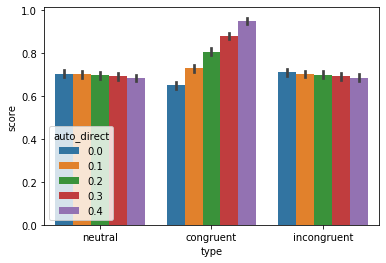

In [58]:
data = []
for d in pytry.read('exp2'):
    score = d['scores']
    stimuli = d['stimuli']
    for i in range(len(score)):
        d2 = dict(d)
        del d2['scores']
        del d2['stimuli']
        d2['score'] = score[i]
        d2['type'] = stimuli[i][2]
        data.append(d2)
df = pandas.DataFrame(data)
seaborn.barplot('type', 'score', hue='auto_direct', data=df)        

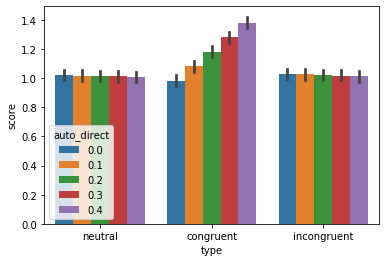

In [59]:
data = []
for d in pytry.read('exp3'):
    score = d['scores']
    stimuli = d['stimuli']
    for i in range(len(score)):
        d2 = dict(d)
        del d2['scores']
        del d2['stimuli']
        d2['score'] = score[i]
        d2['type'] = stimuli[i][2]
        data.append(d2)
df = pandas.DataFrame(data)
seaborn.barplot('type', 'score', hue='auto_direct', data=df)
        